In [1]:
import pandas as pd
import plotly.express as px
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry

# How Does Climate Change Affect Public Health?

### What are the Trends in Average Temperature by Country Over Time?

#### Data Cleaning

In [2]:
# We have a dataset with columns representing the date (YYYY-MM-DD), average temperature, average temperature uncertainty (the 95% confidence interval around the range),
# and country. First, let's clean our data. 

global_land_temps = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
global_land_temps = global_land_temps.rename(columns = {'AverageTemperature': 'AverageTemp_C'})
global_land_temps = global_land_temps[~global_land_temps.isna()].dropna()
global_land_temps['AverageTemp_F'] = global_land_temps['AverageTemp_C'].apply(lambda column: column * 9/5 + 32)
global_land_temps.head()

,dt,AverageTemp_C,AverageTemperatureUncertainty,Country,AverageTemp_F
0,1743-11-01,4.384,2.294,Åland,39.8912
5,1744-04-01,1.530,4.680,Åland,34.7540
6,1744-05-01,6.702,1.789,Åland,44.0636
7,1744-06-01,11.609,1.577,Åland,52.8962
8,1744-07-01,15.342,1.410,Åland,59.6156


#### Data Visualization

In [3]:
# What is the mean temperature by country?
temps_mean = global_land_temps.groupby('Country')['AverageTemp_F'].mean()
temps_mean  = pd.DataFrame(temps_mean).reset_index()
temps_mean.head()

,Country,AverageTemp_F
0,Afghanistan,57.281013
1,Africa,75.333565
2,Albania,54.699163
3,Algeria,73.373201
4,American Samoa,79.901537


In [4]:
# This is a chloropleth that displays the average temperature by country
chloropleth = px.choropleth(
    temps_mean,
    locations = 'Country',
    locationmode= 'country names',
    color = 'AverageTemp_F',
    color_continuous_scale='plasma',
    title = 'Average Temperature by Country'
)
chloropleth

In [5]:
# Finding average change in temperature over 100 years!
# Note: 2013 is the most recent year available in this dataset. 
change_in_temp = global_land_temps[(global_land_temps['dt'] == '1913-01-01') | (global_land_temps['dt'] == '2013-01-01')]
change_in_temp = change_in_temp.sort_values('Country')
change_in_temp['Percent_Change'] = change_in_temp.groupby('Country')['AverageTemp_F'].pct_change() * 100
change_in_temp = change_in_temp.dropna().drop(columns={'dt', 'AverageTemp_C', 'AverageTemperatureUncertainty', 'AverageTemp_F'})

# We have a peculiar outlier here: Svalbard and Jan Mayen has a percent change of 339.53%! 
# Since this is a small country with a disproportionately large change, we will ignore this value for now. 
change_in_temp = change_in_temp.loc[change_in_temp['Percent_Change'] <= 300]

In [6]:
percent_change_graph = px.choropleth(
    change_in_temp,
    locations = 'Country',
    locationmode= 'country names',
    color = 'Percent_Change',
    color_continuous_scale= 'RdBu',
    title = 'Average Temperature Change by Country (1913 to 2013)'
)
percent_change_graph

It looks like most countries did not experience a significant percent change in temperature, but very cold places like Canada, Greenland, Mongolia, experienced a great decrease in temperature over the past century. 

The change in temperatures for these three countries are as follows:
1. Canada: -55.86%
2. Mongolia: -39.88%
3. Greenland: -26.23%

Interesting, Norway also increased a significant decrease in temperature the past century (-22.53%) but other Nordic countries, Sweden and Finland, experienced an increase in temperature (26.36% and 32.35%, respectively).

### Temperature Trends in the United States

In [7]:
# Let's take a closer look at the trend in temperatures in the US over the past few decades. 
us_only = global_land_temps[global_land_temps['Country'] == 'United States']

# Change to datetime and group by decade.
us_only['dt'] = pd.to_datetime(us_only['dt'])
us_only['Decade'] = (us_only['dt'].dt.year // 10) * 10
us_only = pd.DataFrame(us_only[['AverageTemp_F', 'Decade']].groupby(['Decade'])['AverageTemp_F'].mean()).reset_index()
us_only['country'] = 'United States'
us_only

/var/folders/7t/qp5nbn7s1wq8lmyvmpkcc0180000gn/T/ipykernel_92306/4087275938.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7t/qp5nbn7s1wq8lmyvmpkcc0180000gn/T/ipykernel_92306/4087275938.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Decade,AverageTemp_F,country
0,1760,47.879450,United States
1,1770,44.933077,United States
2,1780,44.805855,United States
3,1790,49.135723,United States
4,1810,43.952073,United States
5,1820,47.165585,United States
6,1830,46.756970,United States
7,1840,46.800305,United States
8,1850,47.001695,United States
9,1860,47.143475,United States


In [8]:
us_only_graph = alt.Chart(us_only).mark_line(point = True).encode(
    x = 'Decade:O',
    y = alt.Y('AverageTemp_F:Q', scale = alt.Scale(domain = [40, 55])),
    color = 'country'
).properties(
    title = 'Average Temperature in the United States by Decade (1760s - 2010s)'
)
us_only_graph

alt.Chart(...)

From the graph, we can see that there are dramatic changes in temperature from the 1760s to 1810s (possibly due to a lack of records). Then, from 1820 and onward, there is visibly a generally upward trend in temperature.

In [9]:
# Change in temperature from 1820 to 1910
change_in_temp_part1 = (us_only[us_only['Decade'] == 1910]['AverageTemp_F'].iloc[0] - us_only[us_only['Decade'] == 1820]['AverageTemp_F'].iloc[0]) / (1910 - 1820) * 100
change_in_temp_part1

# There was a 0.098% increase in temperature from 1820 to 1910

0.06984999999999451

In [10]:
change_in_temp_part2 = (us_only[us_only['Decade'] == 2010]['AverageTemp_F'].iloc[0] - us_only[us_only['Decade'] == 1910]['AverageTemp_F'].iloc[0]) / (2010 - 1910) * 100
change_in_temp_part2

# There was a 2.91% increase in temperature from 1910 to 2010

2.9104700000000037

In [11]:
change_in_temp_part2 / change_in_temp_part1

41.66743020759101

The change in temperature in the United States from 1910 to 2010 was about 41.67 times more compared to the change in temperature from 1820 to 1910!

In [12]:
# Now, let's investigate the change in temperature by state
states = pd.read_csv('GlobalLandTemperaturesByState.csv')
states = states[states['Country'] == 'United States'].dropna()
states

# Change to datetime and group by decade.
states['dt'] = pd.to_datetime(states['dt'])
states['Decade'] = (states['dt'].dt.year // 10) * 10
states['AverageTemp_F'] = states['AverageTemperature'].apply(lambda column: column * 9/5 + 32)
states = pd.DataFrame(states[['AverageTemp_F', 'Decade', 'State']].groupby(['State', 'Decade'])['AverageTemp_F'].mean()).reset_index()

# Now we have a DataFrame of all the states and the average temperature in Fahrenheit. To make our data easier to visualize, we will separate these into regions.
northeast = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania']
midwest = ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota']
south = ['Delaware', 'Florida', 'Georgia (State)', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'District of Columbia', 'West Virginia', 'Alabama', 'Kentucky',\
          'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas', 'District Of Columbia']
west = ['Alaska', 'California', 'Hawaii', 'Oregon', 'Washington', 'Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming']

states.loc[states['State'].isin(northeast), 'Region'] = 'Northeast'
states.loc[states['State'].isin(midwest), 'Region'] = 'Midwest'
states.loc[states['State'].isin(south), 'Region'] = 'South'
states.loc[states['State'].isin(west), 'Region'] = 'West'

states.head()

,State,Decade,AverageTemp_F,Region
0,Alabama,1740,59.957185,South
1,Alabama,1750,61.657142,South
2,Alabama,1760,61.736245,South
3,Alabama,1770,62.201798,South
4,Alabama,1780,62.223567,South


In [13]:
state_map = alt.Chart(states).mark_line(point = True).encode(
    x = 'Decade:O',
    y = alt.Y('mean(AverageTemp_F):Q', scale = alt.Scale(domain = [35, 65])),
    color = 'Region:N'
).properties(
    title = 'Average Temperature in the United States by Decade (1760s - 2010s)'
)

national_mean = alt.Chart(states).mark_line(color = 'black', strokeWidth=3).encode(
    x = 'Decade:O',
    y = alt.Y('mean(AverageTemp_F):Q', scale = alt.Scale(domain = [35, 65]))
)

national_temp = alt.Chart({'values':[{}]}).mark_text(
    text=["<- National Mean Temperature"],
    fontSize=10,
    align='right',
    baseline='middle'
).encode(
    x=alt.value(680),
    y=alt.value(120),
)

dotted_line = alt.Chart(pd.DataFrame({'Decade': [1810]})).mark_rule(strokeDash=[3, 3], color='red').encode(
    x='Decade:O'
)

cold_friday = alt.Chart({'values':[{}]}).mark_text(
    text = ['<- The Cold Winter', 'of 1810'],
    fontSize = 10,
    align = 'left',
    baseline = 'middle'
).encode(
    x = alt.value(160),
    y = alt.value(20)
)

state_map + national_mean + national_temp + dotted_line + cold_friday

alt.LayerChart(...)

Now that we have a graph of the average temperature in the United States, we can see how each region of the United States compares to each other. The Northeast, West, and Midwest were generally below the national mean temperature, and the South was generally above the national mean temperature, which makes sense since the South is lower in latitude. Overall, it is pretty evident that there is an overall increase in temperature from the 1700s to the 2000s, which is evidence that global warming is slowly, but surely, happening. For each region, the differences in temperature for each decade are very nominal, usually being about a degree in Fahrenheit or less. 

There is a noticeable dip in average temperature in the 1810s. According to Historic Ipswich, January 19, 1810, was known as the "Cold Friday of 1810" because of the freezing, stark temperatures it brought. In 24 hours, temperatures fell as much as 55 degrees. Henry David Thoreau, an American naturalist and essayist, wrote
> “Began snowing yesterday afternoon–& it is still snowing this forenoon–Mother remembers the Cold Friday–very well–She lived in the house where I was born–The people in the kitchen Jack Garrison–Ester–& a Hardy girl drew up close to the fire–but the dishes which the Hardy girl was washing froze as fast as she washed them close to the fire. They managed to keep warm in the parlor by their great fires.”

Historic Ipswich also describes journals and court records that told of the dreary and frightening weather during this time: people freezing to death, building structures blown apart, trees broken down, and ships wrecked. Shockingly, several journals claimed the temperature in Boston, Massachusetts, dropped more than 100 degrees in less than 24 hours; it dropped from about 67 to -33 degrees Fahrenheit.

source: https://historicipswich.net/2023/01/25/the-cold-friday-of-1810-new-england-historical-society/

Unsurprisingly, the sudden drop in temperature led to physical and emotional burdens, caused by the struggle to survive in temperatures people were unaccustomed to and coping with death, especially since less doctors were available in the past. Adults, especially, had to navigate this challenge and continue to be an inspiration for their children despite never dealing with changes in temperature this extreme before.

### Temperature Trends in Canada

We saw that Canada had a dip in temperature while the United States generally increased, which is very intriguing, considering Canada and the United States are bordering countries.

In [14]:
canada_only = global_land_temps[global_land_temps['Country'] == 'Canada']
canada_only.head()

,dt,AverageTemp_C,AverageTemperatureUncertainty,Country,AverageTemp_F
97255,1768-09-01,5.257,3.107,Canada,41.4626
97256,1768-10-01,-3.393,2.981,Canada,25.8926
97257,1768-11-01,-12.829,3.967,Canada,8.9078
97258,1768-12-01,-20.582,4.622,Canada,-5.0476
97259,1769-01-01,-24.756,4.722,Canada,-12.5608


# Scratch-- delete later

In [15]:
date = pd.to_datetime('2013-01-01')

In [16]:
(global_land_temps[(global_land_temps['Country'] == 'Canada') & (global_land_temps['dt'] == '2013-01-01')]['AverageTemp_F'].iloc[0])

-6.939400000000006

In [17]:
global_land_temps[(global_land_temps['Country'] == 'Canada') & (global_land_temps['dt'] == '1919-01-01')]['AverageTemp_F'].iloc[0]

-6.005200000000002

In [18]:
-6.939400000000006 - (-6.005200000000002) / 100 * 100

-0.9342000000000041

# End scratch

In [19]:
# Change to datetime and group by decade.
canada_only['dt'] = pd.to_datetime(canada_only['dt'])
canada_only['Decade'] = (canada_only['dt'].dt.year // 10) * 10
canada_only = pd.DataFrame(canada_only[['AverageTemp_F', 'Decade']].groupby(['Decade'])['AverageTemp_F'].mean()).reset_index()
canada_only['country'] = 'Canada'
canada_only

/var/folders/7t/qp5nbn7s1wq8lmyvmpkcc0180000gn/T/ipykernel_92306/1917305763.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7t/qp5nbn7s1wq8lmyvmpkcc0180000gn/T/ipykernel_92306/1917305763.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Decade,AverageTemp_F,country
0,1760,23.154500,Canada
1,1770,21.120534,Canada
2,1780,23.249347,Canada
3,1790,24.942477,Canada
4,1810,18.376603,Canada
5,1820,22.117790,Canada
6,1830,21.678665,Canada
7,1840,21.685220,Canada
8,1850,21.939935,Canada
9,1860,21.712610,Canada


In [20]:
canada_only_graph = alt.Chart(canada_only).mark_line(point = True).encode(
    x = 'Decade:O',
    y = alt.Y('AverageTemp_F:Q', scale = alt.Scale(domain = [15, 30])),
    
    color = 'country'
    
).properties(
    title = 'Average Temperature in Canada vs. the United States by Decade (1760s - 2010s)'
)

chart = (canada_only_graph + us_only_graph)
chart

alt.LayerChart(...)

Contrary to what the world map revealed earlier, the United States and Canada both experienced similar trends in temperature over time. As you can see, the lines seem are generally parally, experiencing upward trends in temperature from 1780 - 1790, and then a sudden dip in the year 1810. Afterwards, the temperature is in both countries is overall stable but rises slowly as decades past. More recent decades have temperatures rising exponentially quicker than longer ago, which is more evident in Canada.

### Correlation Analysis

#### Is there a correlation between average temperature and air quality metrics (e.g., PM2.5 levels, AQI)?

In [21]:
# Let's look at another dataset about air pollution. We are interested in the mean AQI value for CO, Ozone, NO2, and PM2.5.
air_pollution = pd.read_csv('global_air_pollution_dataset.csv').drop(columns=['City'])
air_pollution = air_pollution.groupby('Country')[['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']].mean().reset_index()

# Add country iso alpha-3 to make our data easier to deal with
def get_country_code(country_name):
    try:
        country = pycountry.countries.search_fuzzy(country_name)
        if country:
            return country[0].alpha_3
        else:
            return "Unknown"
    except:
        return "Unknown"
    
air_pollution['country_code'] = air_pollution['Country'].apply(get_country_code)

# Manually add iso alpha-3 codes
air_pollution.loc[air_pollution['Country'] == 'Bolivia (Plurinational State of)', 'country_code'] = 'BOL'
air_pollution.loc[air_pollution['Country'] == 'Democratic Republic of the Congo', 'country_code'] = 'COD'
air_pollution.loc[air_pollution['Country'] == 'Iran (Islamic Republic of)', 'country_code'] = 'IRN'
air_pollution.loc[air_pollution['Country'] == 'Turkey', 'country_code'] = 'TUR'
air_pollution.loc[air_pollution['Country'] == 'Venezuela (Bolivarian Republic of)', 'country_code'] = 'VEN'
air_pollution.head()

SubdivisionHierarchy(code='NL-AW', country_code='NL', name='Aruba', parent_code=None, type='Country')
SubdivisionHierarchy(code='BZ-BZ', country_code='BZ', name='Belize', parent_code=None, type='District')
SubdivisionHierarchy(code='US-GA', country_code='US', name='Georgia', parent_code=None, type='State')
SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='GN-ML', country_code='GN', name='Mali', parent='L', parent_code='GN-L', type='Prefecture')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='NG-NI', country_code='NG', name='Niger', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-

,Country,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,country_code
0,Afghanistan,95.959184,0.591837,40.183673,0.020408,95.918367,AFG
1,Albania,68.250000,1.000000,42.062500,0.718750,68.093750,ALB
2,Algeria,88.166667,1.916667,47.166667,9.333333,80.250000,DZA
3,Andorra,29.333333,0.666667,29.333333,0.000000,22.000000,AND
4,Angola,83.925926,3.148148,22.703704,1.888889,81.925926,AGO


In [22]:
# To compare datasets, let's just look at the mean temperature for the most recent decade (2010s)
global_land_temps['dt'] = pd.to_datetime(global_land_temps['dt'])
global_land_temps['Decade'] = (global_land_temps['dt'].dt.year // 10) * 10
global_land = global_land_temps.drop(columns = ['dt', 'AverageTemp_C'])
global_land_recent = pd.DataFrame(global_land[global_land['Decade'] == 2010].groupby('Country')['AverageTemp_F'].mean()).reset_index()


# Add country three-digit codes to make our data easier to deal with
global_land_recent['country_code'] = global_land_recent['Country'].apply(get_country_code)
global_land_recent[global_land_recent['country_code'] == 'Unknown']

# Not everything is a country! Notice we have continents included here too; we will drop them. 
# Drop continents
to_drop = ['Asia', 'Europe', 'North America', 'Oceania', 'South America']
# Drop countries that end with (Europe); these are redundant. Also drop areas with disagreement about whether it is a country (for the sake of this project)
to_drop.extend(['Denmark (Europe)', 'France (Europe)', 'Gaza Strip', 'Macau',
       'Netherlands (Europe)', 'United Kingdom (Europe)'])
global_land_dropped = global_land_recent[~global_land_recent['Country'].isin(to_drop)]

# Manually change the country code for countries with a country code marked as "Unknown"
global_land_dropped.loc[global_land_dropped['Country'] == 'Bonaire, Saint Eustatius And Saba', 'country_code'] = 'BES'
global_land_dropped.loc[global_land_dropped['Country'] == 'Burma', 'country_code'] = 'MMR' # also known as Myanmar
global_land_dropped.loc[global_land_dropped['Country'] == 'Cape Verde', 'country_code'] = 'CPV' # also known as Cabo Verde
global_land_dropped.loc[global_land_dropped['Country'] == 'Congo (Democratic Republic Of The)', 'country_code'] = 'COD'
global_land_dropped.loc[global_land_dropped['Country'] == 'Falkland Islands (Islas Malvinas)', 'country_code'] = 'FLK'
global_land_dropped.loc[global_land_dropped['Country'] == 'French Southern And Antarctic Lands', 'country_code'] = 'ATF'
global_land_dropped.loc[global_land_dropped['Country'] == 'Guinea Bissau', 'country_code'] = 'GNB'
global_land_dropped.loc[global_land_dropped['Country'] == 'Palestina', 'country_code'] = 'PSE'
global_land_dropped.loc[global_land_dropped['Country'] == 'Swaziland', 'country_code'] = 'SWZ' # also known as Eswatini
global_land_dropped.loc[global_land_dropped['Country'] == 'Timor Leste', 'country_code'] = 'TLS'
global_land_dropped.loc[global_land_dropped['Country'] == 'Turkey', 'country_code'] = 'TUR'
global_land_dropped.loc[global_land_dropped['Country'] == 'Turks And Caicas Islands', 'country_code'] = 'TCA'
global_land_dropped.head()



SubdivisionHierarchy(code='US-AS', country_code='US', name='American Samoa', parent_code=None, type='Outlying area')
SubdivisionHierarchy(code='NL-AW', country_code='NL', name='Aruba', parent_code=None, type='Country')
SubdivisionHierarchy(code='UM-81', country_code='UM', name='Baker Island', parent_code=None, type='Islands, groups of islands')
SubdivisionHierarchy(code='BZ-BZ', country_code='BZ', name='Belize', parent_code=None, type='District')
SubdivisionHierarchy(code='NL-CW', country_code='NL', name='Curaçao', parent_code=None, type='Country')
SubdivisionHierarchy(code='DJ-DJ', country_code='DJ', name='Djibouti', parent_code=None, type='City')
SubdivisionHierarchy(code='US-GA', country_code='US', name='Georgia', parent_code=None, type='State')
SubdivisionHierarchy(code='FR-971', country_code='FR', name='Guadeloupe', parent='GP', parent_code='FR-GP', type='Overseas department')
SubdivisionHierarchy(code='FR-GP', country_code='FR', name='Guadeloupe', parent_code=None, type='Overseas

,Country,AverageTemp_F,country_code
0,Afghanistan,59.908509,AFG
1,Africa,77.060914,ZAF
2,Albania,57.027936,ALB
3,Algeria,76.212418,DZA
4,American Samoa,81.095409,ASM


In [23]:
merged = pd.merge(air_pollution, global_land_dropped, on = 'country_code')
merged = (merged
          .drop(columns=['Country_y'])
          .rename(columns = {'Country_x':'Country'})
          .groupby('Country')[['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value', 'AverageTemp_F']].mean())
merged.head()

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,AverageTemp_F
Country,,,,,,
Afghanistan,95.959184,0.591837,40.183673,0.020408,95.918367,59.908509
Albania,68.250000,1.000000,42.062500,0.718750,68.093750,57.027936
Algeria,88.166667,1.916667,47.166667,9.333333,80.250000,76.212418
Andorra,29.333333,0.666667,29.333333,0.000000,22.000000,54.100932
Angola,83.925926,3.148148,22.703704,1.888889,81.925926,72.175877


In [24]:
merged.corr()

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,AverageTemp_F
AQI Value,1.000000,0.693498,0.379754,0.645814,0.996204,0.206821
CO AQI Value,0.693498,1.000000,-0.067168,0.929414,0.684121,-0.057029
Ozone AQI Value,0.379754,-0.067168,1.000000,-0.046003,0.347364,-0.032040
NO2 AQI Value,0.645814,0.929414,-0.046003,1.000000,0.631638,-0.083097
PM2.5 AQI Value,0.996204,0.684121,0.347364,0.631638,1.000000,0.241096
AverageTemp_F,0.206821,-0.057029,-0.032040,-0.083097,0.241096,1.000000


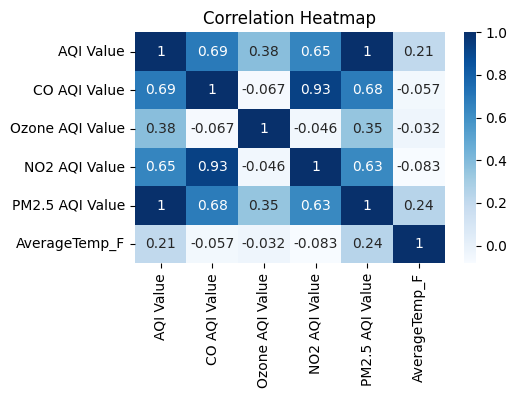

In [25]:
# heatmap to visualize correlations
plt.figure(figsize=(5, 3))
sns.heatmap(merged.corr(), annot=True, cmap='Blues')
plt.title('Correlation Heatmap')
plt.show()

* There is a **strong** association between the AQI and CO AQI Value, and the AQI and NO2 AQI Value
* There is a **strong** association between the NO2 AQI Value and PM2.5 AQI Value
* There is a **very strong** association between the CO2 AQI Value and NO2 AQI Value
* Temperature has a **very weak** association with the CO2, Ozone, and NO2 AQI Values
* Temperature has a **weak** association with the PM2.5 AQI Value

#### Are there any regional differences in these correlations?

In [26]:
# Get country code for country names
with_country_code = pd.merge(air_pollution, global_land_dropped, on = 'country_code')
with_country_code = (with_country_code
          .drop(columns=['Country_y'])
          .rename(columns = {'Country_x':'Country'}))
with_country_code

,Country,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,country_code,AverageTemp_F
0,Afghanistan,95.959184,0.591837,40.183673,0.020408,95.918367,AFG,59.908509
1,Albania,68.250000,1.000000,42.062500,0.718750,68.093750,ALB,57.027936
2,Algeria,88.166667,1.916667,47.166667,9.333333,80.250000,DZA,76.212418
3,Andorra,29.333333,0.666667,29.333333,0.000000,22.000000,AND,54.100932
4,Angola,83.925926,3.148148,22.703704,1.888889,81.925926,AGO,72.175877
...,...,...,...,...,...,...,...,...
176,Venezuela (Bolivarian Republic of),77.722222,1.277778,17.522222,3.866667,77.722222,VEN,78.533968
177,Viet Nam,87.050000,2.366667,46.233333,2.633333,82.483333,VNM,76.207182
178,Yemen,144.571429,1.285714,55.428571,0.714286,144.571429,YEM,81.478318
179,Zambia,40.666667,0.690476,20.190476,0.095238,39.952381,ZMB,71.207682


In [27]:
countries = pd.read_csv('countries.csv')
countries['country_code'] = countries['Country'].apply(get_country_code)
countries

SubdivisionHierarchy(code='US-AS', country_code='US', name='American Samoa', parent_code=None, type='Outlying area')
SubdivisionHierarchy(code='NL-AW', country_code='NL', name='Aruba', parent_code=None, type='Country')
SubdivisionHierarchy(code='BZ-BZ', country_code='BZ', name='Belize', parent_code=None, type='District')
SubdivisionHierarchy(code='DJ-DJ', country_code='DJ', name='Djibouti', parent_code=None, type='City')
SubdivisionHierarchy(code='US-GA', country_code='US', name='Georgia', parent_code=None, type='State')
SubdivisionHierarchy(code='FR-971', country_code='FR', name='Guadeloupe', parent='GP', parent_code='FR-GP', type='Overseas department')
SubdivisionHierarchy(code='FR-GP', country_code='FR', name='Guadeloupe', parent_code=None, type='Overseas region')
SubdivisionHierarchy(code='US-GU', country_code='US', name='Guam', parent_code=None, type='Outlying area')
SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
Subdiv

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,country_code
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0",...,"12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38",AFG
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5",...,"21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579",ALB
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0",...,"3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298",DZA
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0",...,10,15,75,2,"22,46","3,27",NaN,NaN,NaN,ASM
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0",...,"2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN,AND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,NaN,...,"16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63",Unknown
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",NaN,NaN,NaN,NaN,...,"0,02",0,"99,98",1,NaN,NaN,NaN,NaN,"0,4",ESH
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2",...,"2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393",YEM
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6",...,"7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489",ZMB


In [28]:
# We want to find the mean AQI values for each region
countries_by_region = pd.merge(with_country_code, countries, on = 'country_code')[['AQI Value', 'CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value', 'Region']]
countries_by_region

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value,Region
0,95.959184,0.591837,40.183673,0.020408,95.918367,ASIA (EX. NEAR EAST)
1,68.250000,1.000000,42.062500,0.718750,68.093750,EASTERN EUROPE
2,88.166667,1.916667,47.166667,9.333333,80.250000,NORTHERN AFRICA
3,29.333333,0.666667,29.333333,0.000000,22.000000,WESTERN EUROPE
4,83.925926,3.148148,22.703704,1.888889,81.925926,SUB-SAHARAN AFRICA
...,...,...,...,...,...,...
178,77.722222,1.277778,17.522222,3.866667,77.722222,LATIN AMER. & CARIB
179,87.050000,2.366667,46.233333,2.633333,82.483333,ASIA (EX. NEAR EAST)
180,144.571429,1.285714,55.428571,0.714286,144.571429,NEAR EAST
181,40.666667,0.690476,20.190476,0.095238,39.952381,SUB-SAHARAN AFRICA


In [29]:
countries_by_region = countries_by_region.groupby('Region').mean().dropna().reset_index()
countries_by_region

,Region,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
0,ASIA (EX. NEAR EAST),86.508571,1.488839,42.635841,1.896687,83.804170
1,BALTICS,38.958001,1.018075,32.798644,0.545056,32.416932
2,C.W. OF IND. STATES,68.312088,0.939561,38.618165,0.505127,64.965889
3,EASTERN EUROPE,62.230055,1.008750,39.932032,0.925383,60.677318
4,LATIN AMER. & CARIB,63.609962,1.137976,19.687118,2.852028,62.805201
5,NEAR EAST,123.892269,1.418732,85.775076,2.997354,120.079448
6,NORTHERN AFRICA,82.298836,1.322640,48.069214,3.593140,76.208278
7,NORTHERN AMERICA,51.501505,1.260327,27.451733,5.561497,48.479667
8,OCEANIA,24.638788,0.042353,18.540250,0.809590,17.606881
9,SUB-SAHARAN AFRICA,72.078017,1.633648,22.911059,1.021500,71.653999


In [30]:
alt.Chart(countries_by_region).mark_bar().encode(
    x = 'AQI Value:Q',
    y = 'Region:N',
).properties(
    title = 'Air Quality by World Region'
)

alt.Chart(...)

In [31]:
co = alt.Chart(countries_by_region).mark_bar(color = '#BD4F6C').encode(
    x = 'CO AQI Value:Q',
    y = 'Region:N',
).properties(
    title = 'CO Air Quality by World Region'
)

ozone = alt.Chart(countries_by_region).mark_bar(color = '#93B5C6').encode(
    x = 'Ozone AQI Value:Q',
    y = 'Region:N',
).properties(
    title = 'Ozone Air Quality by World Region'
)

no2 = alt.Chart(countries_by_region).mark_bar(color = '#D7816A').encode(
    x = 'NO2 AQI Value:Q',
    y = 'Region:N',
).properties(
    title = 'No2 Air Quality by World Region'
)

countries_by_region = countries_by_region.rename(columns={'PM2.5 AQI Value': 'PM25_AQI_Value'})
pm2_5 = alt.Chart(countries_by_region).mark_bar(color = '#2C6E49').encode(
    x = alt.X('PM25_AQI_Value:Q', title = 'PM2.5 AQI Value'),
    y = alt.Y('Region:N', title = 'Region'),
).properties(
    title = 'PM2.5 Air Quality by World Region'
)

alt.vconcat(alt.hconcat(co, ozone), alt.hconcat(no2, pm2_5)).properties(
    title = 'Air Quality in the World by Pollutant'
)

alt.VConcatChart(...)

There are regional differences in specific pollutants: 
* The Near East has relatively high AQI for all four air pollutants mentioned: CO, Ozone, NO2, and PM2.5
* Compared to other world regions, Northern America releases the most NO2. 
* Oceania appears to have very low AQI (good air quality) compared to the other world regions for all four pollutants. 